In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib
import h5py

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CMv2
import calculation.SusceptibilitySimpv2 as Susceptv2

In [2]:
### Parameters
Tvalue0 = 1e-4
Tvalue1 = 1e-3
Tvalue2 = 1e-2
Tvalue3 = 5e-1

TvalueVec = np.array([Tvalue0, Tvalue1, Tvalue2, Tvalue3])

couplingValue = 0.7

size_vec = 650
voltageSpacePlot = np.geomspace(1e-10, 20.0, size_vec)
lambdaSamples = np.array([1.0])

## Initial Conditions
phiConstantInit = 0.5
phiLambdaInit = 0.9

In [3]:
def computeSaddlePoints(lambdaSamples, Tvalue, voltageSpacePlot, pbar=None):
    
    saddle_points = np.zeros((len(lambdaSamples),len(voltageSpacePlot)), dtype=float)
    
    for j in range(len(lambdaSamples)):
        lambdaValue = lambdaSamples[j]
        for i in range(size_vec):
            voltageValue = voltageSpacePlot[i]
            result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
            saddle_points[j,i] = result.x[0]
            
            if pbar is not None:
                pbar.update(1)
    
    return saddle_points

In [4]:

pbar = tqdm(total=len(lambdaSamples)*size_vec*len(TvalueVec), desc='Computing phi(lambda)')

phi_voltage = np.zeros((len(TvalueVec), len(lambdaSamples), size_vec), dtype=float)

for i in range(len(TvalueVec)):
    Tvalue = TvalueVec[i]
    phi_voltage[i, :,:] = computeSaddlePoints(lambdaSamples, Tvalue, voltageSpacePlot, pbar)

pbar.close()



Computing phi(lambda):   0%|          | 0/2600 [00:00<?, ?it/s]

Computing phi(lambda): 100%|██████████| 2600/2600 [01:10<00:00, 36.97it/s]


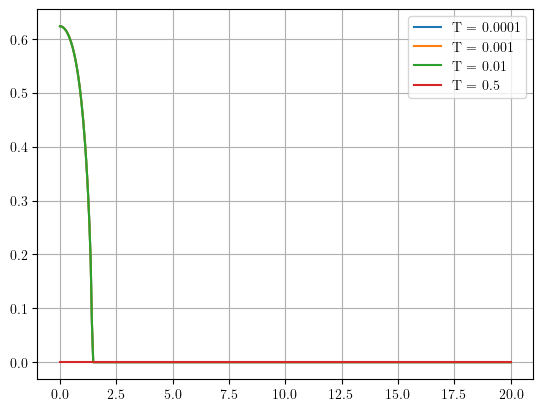

In [5]:
plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
for i in range(len(TvalueVec)):
    plt.plot(voltageSpacePlot, phi_voltage[i,0,:], label='T = '+str(TvalueVec[i]))
    
plt.legend()
plt.grid()

In [6]:
### find saddle points for lambda
def computeSaddlePoints(phiData, xData, eps=1e-2):
    saddle_point = 0.0
    
    for i in range(len(xData)):
        if phiData[i] < eps:
            saddle_point = xData[i-1]
            break
        
    return saddle_point


criticalTZero = computeSaddlePoints(phi_voltage[0,0,:], voltageSpacePlot)
cruticalTLower = computeSaddlePoints(phi_voltage[1,0,:], voltageSpacePlot)
cruticalTLower2 = computeSaddlePoints(phi_voltage[2,0,:], voltageSpacePlot)

# criticalTUpper = computeSaddlePoints(phi_voltage[2,0,:], voltageSpacePlot)


In [7]:
print('Critical T0: ', criticalTZero)
print('Critical T1: ', cruticalTLower)
print('Critical T1: ', cruticalTLower2)

Critical T0:  1.4183150391303192
Critical T1:  1.4183150391303192
Critical T1:  1.4183150391303192


In [8]:

hstep = 1e-4
omegaSpace = np.linspace(-hstep, hstep, 2)

PiR = np.zeros((len(TvalueVec),len(omegaSpace), len(voltageSpacePlot)), dtype=np.complex128)
PiK = np.zeros((len(TvalueVec),len(omegaSpace), len(voltageSpacePlot)), dtype=np.complex128)

lambdaUpper = lambdaSamples[-1]

pbar = tqdm(total=len(voltageSpacePlot)*len(TvalueVec), desc='Computing PiR and PiK')


for i in range(len(voltageSpacePlot)):
   voltageValue = voltageSpacePlot[i]
   for j in range(len(TvalueVec)):
      Tvalue = TvalueVec[j]
      phiValue = phi_voltage[j,-1,i]
      PiR[j,:,i] = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
      PiK[j,:,i] = Susceptv2.computePiKnum(omegaSpace, lambdaUpper, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
      
      pbar.update(1)

pbar.close()


Computing PiR and PiK: 100%|██████████| 2600/2600 [04:28<00:00,  9.68it/s]


In [9]:
print(TvalueVec)

[1.e-04 1.e-03 1.e-02 5.e-01]


Text(0, 0.5, '$\\partial_{\\omega} F|_{\\omega=0}$')

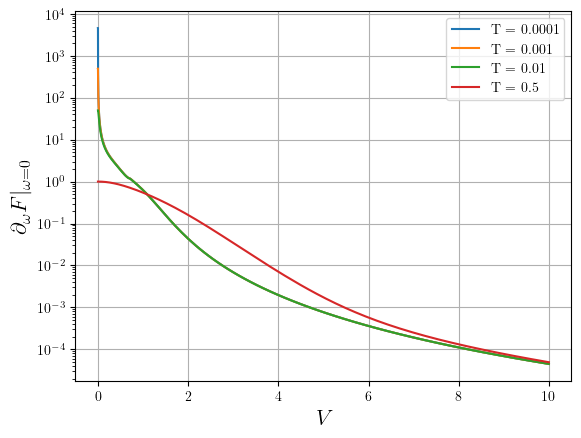

In [10]:

chiR = PiR/(2.0*lambdaUpper**2)
chiK = PiK/(2.0*lambdaUpper**2)

FauxPlus = chiR[:, 1,:].imag/chiK[:, 1,:].imag
FauxMinus = chiR[:, 0,:].imag/chiK[:, 0,:].imag

dFaux = (FauxPlus - FauxMinus)/(2*hstep)


# dFauxTZeroLinear = scipy.interpolate.interp1d(voltageSpacePlot, dFaux[0,:], kind='linear')
# dFauxTLowerLinear = scipy.interpolate.interp1d(voltageSpacePlot, dFaux[1,:], kind='linear')

# dFauxZero = dFauxTZeroLinear(criticalTZero)
# dFauxLower = dFauxTLowerLinear(cruticalTLower)


plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
for i in range(len(TvalueVec)):
    plt.plot(voltageSpacePlot[1:]/2, dFaux[i,1:], label='T = '+str(TvalueVec[i]))
plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel(r'$V$', fontsize=16)
plt.ylabel(r'$\partial_{\omega} F|_{\omega=0}$', fontsize=16)
# plt.savefig('figures/dFomegaSuscept.png', dpi=300)


[1.e-04 1.e-03 1.e-02 5.e-01]
1.0819767580626778
1.0008332047671424
1.000008344646462


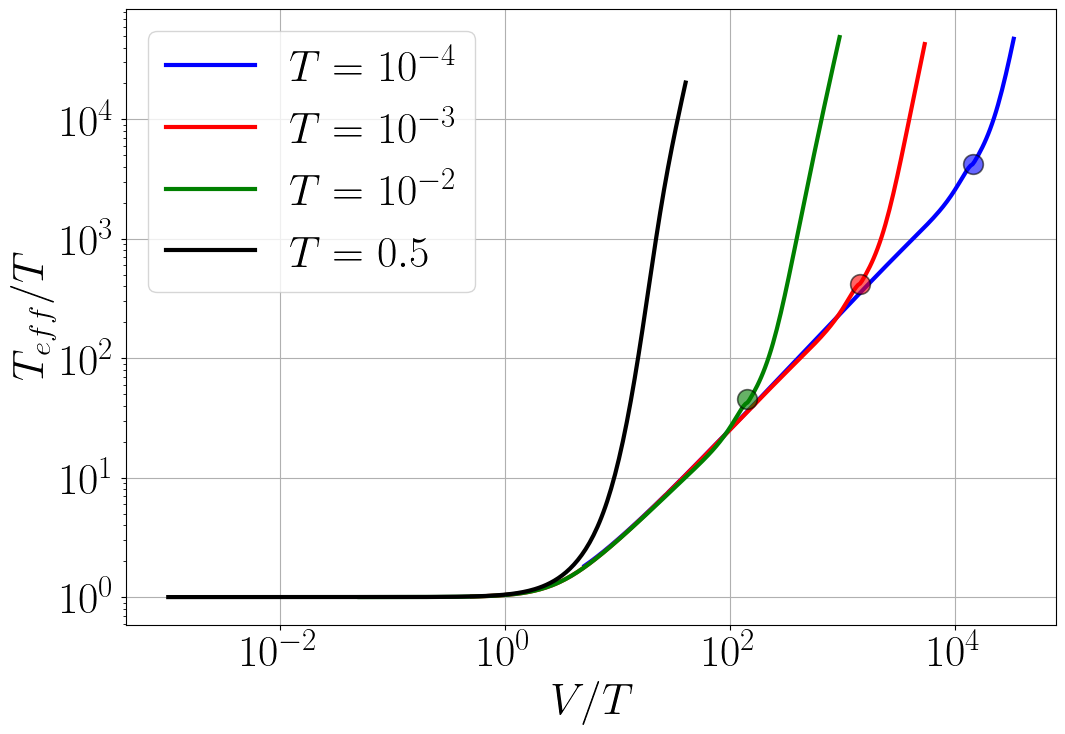

In [12]:

vec_colors = ["blue", "red", "green", "black"]

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

dFaux2 = dFaux.copy()
voltageSpacePlot2 =voltageSpacePlot.copy()

for idx, volt in enumerate(voltageSpacePlot):
    if volt <= 5e-4:
        
        voltageSpacePlot2[idx] = None
        dFaux2[:, idx] = None


for i in range(len(TvalueVec)):
    
    mask = np.where(0.5/dFaux2[i,:]/TvalueVec[i] > 5e4)[0]
    dFaux2[i,mask] = np.nan


print(TvalueVec)

ax.plot(voltageSpacePlot2[:]/TvalueVec[0], 0.5/dFaux2[0,:]/TvalueVec[0], label=r'$T = 10^{-4}$', linewidth=3.0, color=vec_colors[0])
ax.plot(voltageSpacePlot2[:]/TvalueVec[1], 0.5/dFaux2[1,:]/TvalueVec[1], label=r'$T = 10^{-3}$', linewidth=3.0, color=vec_colors[1])
ax.plot(voltageSpacePlot2[:]/TvalueVec[2], 0.5/dFaux2[2,:]/TvalueVec[2], label=r'$T = 10^{-2}$', linewidth=3.0, color=vec_colors[2])
ax.plot(voltageSpacePlot2[:]/TvalueVec[3], 0.5/dFaux2[3,:]/TvalueVec[3], label=r'$T = 0.5$', linewidth=3.0, color=vec_colors[3])

func_1 = scipy.interpolate.UnivariateSpline(voltageSpacePlot[:]/TvalueVec[0], 0.5/dFaux[0,:]/TvalueVec[0], s=0.0)
func_2 = scipy.interpolate.UnivariateSpline(voltageSpacePlot[:]/TvalueVec[1], 0.5/dFaux[1,:]/TvalueVec[1], s=0.0)
func_3 = scipy.interpolate.UnivariateSpline(voltageSpacePlot[:]/TvalueVec[2], 0.5/dFaux[2,:]/TvalueVec[2], s=0.0)

t_eff_1 = func_1(criticalTZero/TvalueVec[0])
t_eff_2 = func_2(cruticalTLower/TvalueVec[1])
t_eff_3 = func_2(cruticalTLower/TvalueVec[2])


ax.scatter(criticalTZero/TvalueVec[0], t_eff_1,
    color='blue',
    edgecolors='black',
    linewidths=1.2,        # width of the edge line
    alpha=0.6,             # optional transparency
    marker='o',            # circle markers (default)
    zorder=2,
    s=200
)
ax.scatter(cruticalTLower/TvalueVec[1], t_eff_2,
    color='red',
    edgecolors='black',    # dark outline for every dot
    linewidths=1.2,        # width of the edge line
    alpha=0.6,             # optional transparency
    marker='o',            # circle markers (default)
    zorder=2,
    s=200
)

ax.scatter(cruticalTLower/TvalueVec[2], t_eff_3+10,
    color='green',
    edgecolors='black',    # dark outline for every dot
    linewidths=1.2,        # width of the edge line
    alpha=0.6,             # optional transparency
    marker='o',            # circle markers (default)
    zorder=2,
    s=200
)

print(0.5/dFaux[0,1]/TvalueVec[0])
print(0.5/dFaux[1,1]/TvalueVec[1])
print(0.5/dFaux[2,1]/TvalueVec[2])

ax.tick_params(axis='y', labelsize=32)
ax.tick_params(axis='x', labelsize=32)

# plt.ylim(1e-1, 1e8)
# plt.xlim(6e-3, 3e4)
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1e-3, 2.2e1)
plt.grid()
plt.legend(fontsize=32, loc='upper left')
plt.xlabel(r'$V/T$', fontsize=32)
plt.ylabel(r'$T_{eff}/T$', fontsize=32)


# plt.savefig('panels/Teff_T_vs_V-Vc.png')
plt.savefig('panels/TSusceptRangeTTsVoltageV2.png', bbox_inches='tight', dpi=600)